# Generating CIFAR Images with Deep Convolutional GAN

In this Notebook, we show how to generate data using Deep Convolutional Neural Networks in a GAN setup to generate more complex images from the CIFAR dataset.

Papers:
* [DC-GAN](https://arxiv.org/pdf/1511.06434.pdf)

In [1]:
!gpustat

phoebe  Thu May 24 11:30:33 2018
[0] GeForce GTX 1080 Ti | 67'C,  98 % |  8686 / 11172 MB | valv(7815M) s132314(861M)
[1] GeForce GTX 1080 Ti | 73'C,  97 % |  7161 / 11172 MB | valv(7151M)
[2] GeForce GTX 1080 Ti | 73'C,  66 % |  1211 / 11172 MB | valv(1201M)
[3] GeForce GTX 1080 Ti | 68'C,  64 % |  1227 / 11172 MB | valv(1217M)
[4] GeForce GTX 1080 Ti | 71'C,  99 % |  8623 / 11172 MB | valv(8613M)
[5] GeForce GTX 1080 Ti | 36'C,   2 % |     0 / 11172 MB |
[6] GeForce GTX 1080 Ti | 54'C,  10 % |   459 / 11172 MB | valv(449M)
[7] GeForce GTX 1080 Ti | 54'C,   0 % |  4717 / 11172 MB | valv(623M) valv(3265M) valv(819M)


In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## The Data

For this experiment, we will use the traditional MNIST dataset.

In [3]:
def getData():
    compose = transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
    out_dir = '/scratch/CIFAR10'
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)
# Load data
dataset = getData()
L = dataset[0][0].shape[2]
print("Image shape:",dataset[0][0].shape)

Files already downloaded and verified
Image shape: torch.Size([3, 32, 32])


## DC-GAN 

DC-GAN is GAN with convolutional neural networks. According to the original paper, a few rules need to be respected:

* strided convolutions instead of max pooling layers
* no fully connected layers
* batch norm in $G$ and $D$
* LeayReLU for the non linearities in the discriminator

For this experiment, we keep use the Wassertein loss and the gradient penalisation from WGAN-GP, therefore **no BatchNorm** will be used for the discrimnator $D$.

### Modules

In [4]:
import numpy as np
import torch
import torch.nn as nn
    
class ResidualBlock(nn.Module):
    """
    Residual Block
    """
    def __init__(self, num_filters, kernel_size, padding, nonlinearity=nn.ReLU, dropout=0.2, dilation=1,batchNormObject=None):
        super(ResidualBlock, self).__init__()
        num_hidden_filters = num_filters
        self.conv1 = nn.Conv2d(num_filters, num_hidden_filters, kernel_size=kernel_size,stride=1,padding=padding,dilation=dilation )
        self.dropout = nn.Dropout2d(dropout)
        self.nonlinearity = nonlinearity(inplace=False)
        self.batch_norm1 = batchNormObject(num_hidden_filters)
        self.conv2 = nn.Conv2d(num_hidden_filters, num_hidden_filters, kernel_size=kernel_size,stride=1,padding=padding,dilation=dilation )
        self.batch_norm2 = batchNormObject(num_filters)

    def forward(self, og_x):
        x = og_x
        x = self.dropout(x)
        x = self.conv1(og_x)
        if self.batch_norm1 is not None:
            x = self.batch_norm1(x)
        x = self.nonlinearity(x)
        x = self.conv2(x)
        out = og_x + x
        if self.batch_norm2 is not None:
            out = self.batch_norm2(out)
        out = self.nonlinearity(out)
        return out
    
class ConvolutionalEncoder(nn.Module):
    """
    Convolutional Encoder
    """
    def __init__(self,n_features_input,num_hidden_features,kernel_size,padding,n_resblocks,dropout_min=0,dropout_max=0.2, blockObject=ResidualBlock,batchNormObject=nn.BatchNorm2d,activation=nn.ReLU):
        """
        n_features_input (int): number of intput features
        num_hidden_features (list(int)): number of features for each stage
        kernel_size (int): convolution kernel size
        padding (int): convolution padding
        n_resblocks (int): number of residual blocks at each stage
        dropout (float): dropout probability
        blockObject (nn.Module): Residual block to use. Default is ResidualBlock
        batchNormObject (nn.Module): normalization layer. Default is nn.BatchNorm2d
        """
        super(ConvolutionalEncoder,self).__init__()
        self.n_features_input = n_features_input
        self.num_hidden_features = num_hidden_features
        self.stages = nn.ModuleList()
        dropout = iter([(1-t)*dropout_min + t*dropout_max   for t in np.linspace(0,1,(len(num_hidden_features)))])
        dropout = iter(dropout)
        # input convolution block
        block = [nn.Conv2d(n_features_input, num_hidden_features[0], kernel_size=kernel_size,stride=1, padding=padding)]
        for _ in range(n_resblocks):
            p = next(iter(dropout))
            block += [blockObject(num_hidden_features[0], kernel_size, padding, dropout=p,batchNormObject=batchNormObject)]
        self.stages.append(nn.Sequential(*block))
        # layers
        for features_in,features_out in [num_hidden_features[i:i+2] for i in range(0,len(num_hidden_features), 1)][:-1]:
            # downsampling
            block = [nn.Conv2d(features_in, features_out, kernel_size=kernel_size,stride=2,padding=padding ),batchNormObject(features_out),activation()]
            # residual blocks
            p = next(iter(dropout))
            for _ in range(n_resblocks):
                block += [blockObject(features_out, kernel_size, padding, dropout=p,batchNormObject=batchNormObject)]
            self.stages.append(nn.Sequential(*block)) 
            
    def forward(self,x):
        for stage in self.stages:
            x = stage(x)
        return x
    def getInputShape(self):
        return (-1,self.n_features_input,-1,-1)
    def getOutputShape(self):
        return (-1,self.num_hidden_features[-1], -1,-1)
    
            
class ConvolutionalDecoder(nn.Module):
    """
    Convolutional Decoder taking skip connections
    """
    def __init__(self,n_features_output,num_hidden_features,kernel_size,padding,n_resblocks,dropout_min=0,dropout_max=0.2,blockObject=ResidualBlock,batchNormObject=nn.BatchNorm2d,activation=nn.ReLU):
        """
        n_features_output (int): number of output features
        num_hidden_features (list(int)): number of features for each stage
        kernel_size (int): convolution kernel size
        padding (int): convolution padding
        n_resblocks (int): number of residual blocks at each stage
        dropout (float): dropout probability
        blockObject (nn.Module): Residual block to use. Default is ResidualBlock
        batchNormObject (nn.Module): normalization layer. Default is nn.BatchNorm2d
        """
        super(ConvolutionalDecoder,self).__init__()
        self.n_features_output = n_features_output
        self.num_hidden_features = num_hidden_features
        self.upConvolutions = nn.ModuleList()
        self.residualBlocks = nn.ModuleList()
        dropout = iter([(1-t)*dropout_min + t*dropout_max   for t in np.linspace(0,1,(len(num_hidden_features)))][::-1])
        # input convolution block
        # layers
        for features_in,features_out in [num_hidden_features[i:i+2] for i in range(0,len(num_hidden_features), 1)][:-1]:
            # downsampling
            self.upConvolutions.append(nn.Sequential(nn.ConvTranspose2d(features_in, features_out, kernel_size=4, stride=2,padding=1 ),batchNormObject(features_out),activation()))
            # residual blocks
            block = []
            p = next(iter(dropout))
            for _ in range(n_resblocks):
                block += [blockObject(features_out, kernel_size, padding, dropout=p,batchNormObject=batchNormObject)]
            self.residualBlocks.append(nn.Sequential(*block))   
        # output convolution block
        block = [nn.Conv2d(num_hidden_features[-1],n_features_output, kernel_size=kernel_size,stride=1, padding=padding)]
        self.output_convolution = nn.Sequential(*block)

    def forward(self,x):
        for up,merge,conv in zip(self.upConvolutions,self.residualBlocks,skips):
            x = up(x)
            x = conv(x)
        return self.output_convolution(x)
    def getInputShape(self):
        return (-1,self.num_hidden_features[0],-1,-1)
    def getOutputShape(self):
        return (-1,self.n_features_output, -1,-1)
    

    

In [16]:
class Generator(nn.Module):
    '''
        Generative Network
    '''
    def __init__(self, z_size=100, out_size=3, ngf=128):
        super(Generator, self).__init__()
        self.z_size = z_size
        self.ngf = ngf
        self.out_size = out_size

        self.main = nn.Sequential(
            # input size is z_size
            nn.ConvTranspose2d(self.z_size, self.ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 1, bias=False),
            nn.Tanh()
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):

        output = self.main(input)

        return output

# D
class Discriminator(nn.Module):
    '''
        Discriminative Network
    '''
    def __init__(self, in_size=3, ndf=128):
        super(Discriminator, self).__init__()
        self.in_size = in_size
        self.ndf = ndf

        self.main = nn.Sequential(
            nn.Conv2d(self.in_size, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf * 4, 1, 4, 1, 0, bias=False)#,nn.Sigmoid()
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):

        output = self.main(input)

        return output

### Some Utilities

In [17]:
def images_to_vectors(images):
    """
    flatten batch of images
    """
    return images.view(images.size(0), L**2)

def vectors_to_images(vectors):
    """
    reconstruct batch of images from batch of flattened images
    """
    return vectors.view(vectors.size(0), 1, L, L)

def noise(size,noise_dim):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = torch.randn(size, noise_dim)
    return n.to(device)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)


def oneHot(y,data_dim):
    shp = y.size()
    y = y.view(-1,1)
    y_onehot = torch.LongTensor(y.size()[0], data_dim)
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1)
    return y_onehot.view(*shp[:-1],data_dim).contiguous()

import torch.nn.init as init
def weights_init(m):
    if isinstance(m, nn.Conv2d): 
        if m.conv.weight is not None:
            if m.he_init:
                init.kaiming_uniform_(m.conv.weight)
            else:
                init.xavier_uniform_(m.conv.weight)
        if m.conv.bias is not None:
            init.constant_(m.conv.bias, 0.0)
    if isinstance(m, nn.Linear):
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)

##### WGAN-GP: gradients penalty

In [18]:
LAMBDA = 10 # recommended value from the original paper

def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1).requires_grad_()
    alpha = alpha[:,:,None,None]
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device) 

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

## Training

In [19]:
condition_dim = 10
batch_size = 128
m = int(np.sqrt(batch_size))-1
lr = 1e-3
dropout = 0.3
noise_dim = 100
num_layers = 2
n_out = L**2
clipping_value = 1e-2
n_features = 64

num_test_samples = m**2
test_noise = noise(num_test_samples,noise_dim)[:,:,None,None]

# models
try:
    del generator
except:
    0
try:
    del discriminator
except:
    0
generator = Generator(ngf=n_features).to(device)
discriminator = Discriminator(ndf=n_features).to(device)
# otpimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)#, betas=(0,0.9))
g_optimizer = optim.Adam(generator.parameters(), lr=lr)#, betas=(0,0.9)) #RMSprop
loss = nn.BCELoss()

# data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error"])
# Total number of epochs to train
num_epochs = 200
global_step=0
epoch =0
g_error = 0

#### Training $D$

In [20]:
def train_discriminator(optimizer, real_data, real_labels, fake_data, fake_labels):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    real_input = real_data #torch.cat(real_data,real_labels],1)
    prediction_real = discriminator(real_input).squeeze()
    #loss_real = - prediction_real.mean()
    
    # 1.2 Train on Fake Data
    fake_input = fake_data #torch.cat([fake_data,fake_labels],1)
    prediction_fake = discriminator(fake_input).squeeze()
    #loss_fake = prediction_fake.mean()
    
    # gradients penalty (Lipschitz condition) (WGAN-GP)
    penalty = calc_gradient_penalty(discriminator,real_input, fake_input)
    loss = prediction_fake.mean() - prediction_real.mean() + penalty
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # 1.4 clip D parameters (Lipschitz condition) (orignal WGAN)
    #for p in discriminator.parameters():
    #    p.data.clamp_(-clipping_value, clipping_value)
    
    
        
    # Return error and predictions for real and fake inputs
    return loss

#### Training $G$

In [21]:
def train_generator(optimizer, fake_data, fake_labels):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data).squeeze() #discriminator(torch.cat([fake_data,fake_labels],1))
    # Calculate error and backpropagate
    G_loss = - torch.mean(prediction)
    G_loss.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return G_loss

#### Full Training

The discrimator is trained more steps than the generator

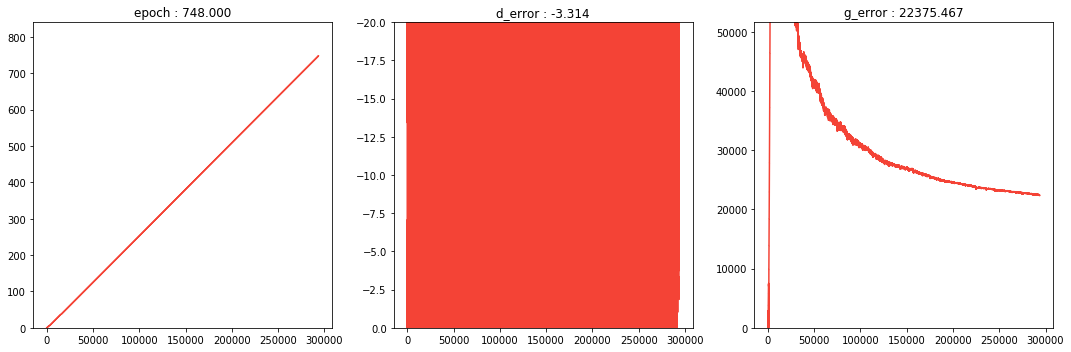

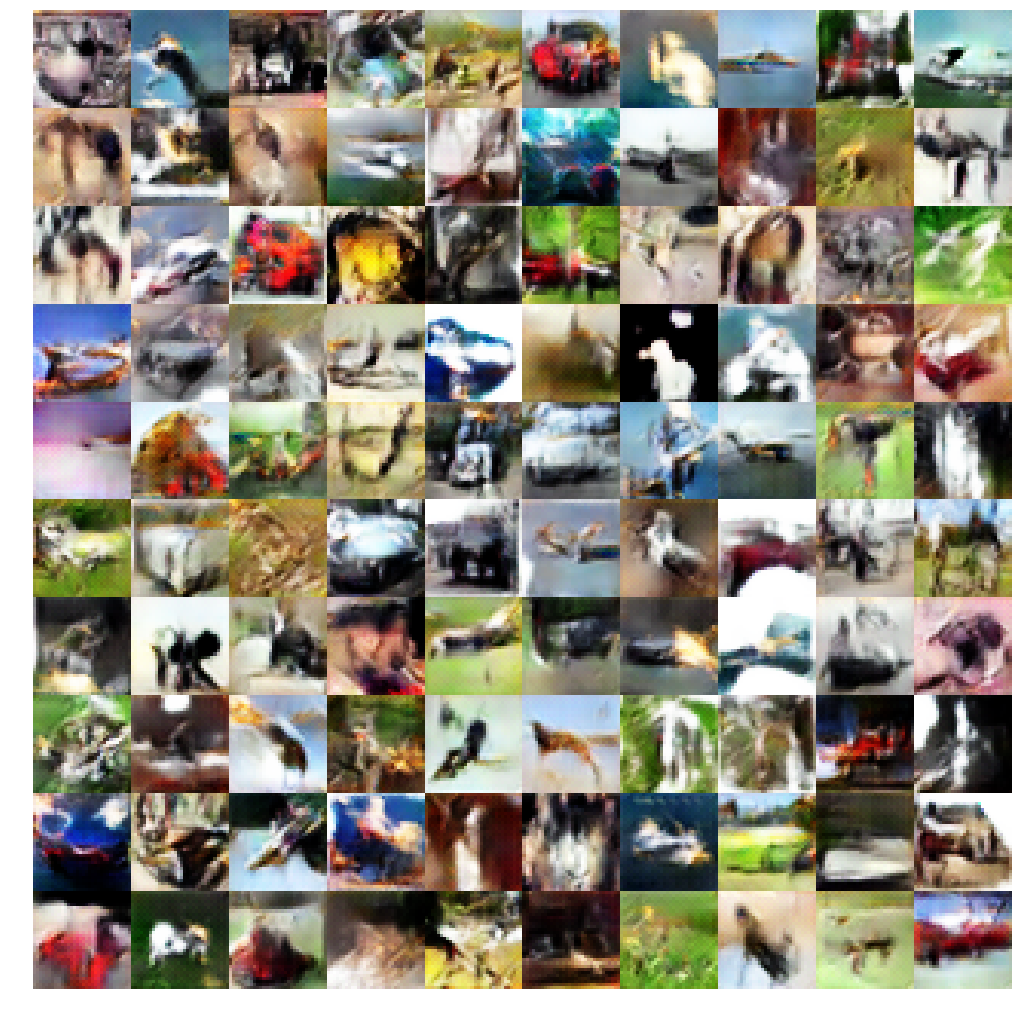

In [ ]:
gen_steps = 1
gen_train_freq = 1
if True:
    while True:
        for n_batch, (real_batch,label_batch) in enumerate(data_loader):
            #one hot labels
            label_batch = oneHot(label_batch[:,None],10).float().to(device)
            N = real_batch.size(0)
            # 1. Train Discriminator
            real_data = real_batch.to(device) #images_to_vectors(real_batch).to(device)
            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = noise(N,noise_dim)[:,:,None,None]
            random_labels = torch.randint(10, size=(N,1) ).long()
            random_labels = oneHot(random_labels,10).float().to(device)
            with torch.no_grad():
                fake_data = generator(noise_tensor)# torch.cat([noise_tensor,random_labels],1)).detach()
            # Train D
            d_error = train_discriminator(d_optimizer, real_data,label_batch, fake_data,random_labels)

            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # 2. Train Generator
                    # Generate fake data
                    noise_tensor = noise(N,noise_dim)[:,:,None,None]
                    random_labels = torch.randint(10, size=(N,1) ).long()
                    random_labels = oneHot(random_labels,10).float().to(device)
                    fake_data = generator(noise_tensor) #torch.cat([noise_tensor,random_labels],1))
                    # Train G
                    g_error = train_generator(g_optimizer, fake_data,random_labels)
                    g_error = g_error.item()
            # Log batch error
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error} )
            global_step+=1
            del fake_data
            del real_data
            del noise_tensor
            # Display Progress every few batches
            if global_step % 50 == 0:
                labels = torch.from_numpy(np.asarray([[k for k in range(m)] for _ in range(m)]).flatten())
                labels = oneHot(labels[:,None],10).float().to(device)
                test_images = generator(test_noise).squeeze() 
                test_images = test_images.data
                canvas = np.zeros((L*m,L*m,3))
                q = 0
                for i in range(m):
                    for j in range(m):
                        tile = test_images[q].permute(1,2,0)
                        tile = (tile-tile.min())/(tile.max()-tile.min())
                        canvas[i*L:(i+1)*L,j*L:(j+1)*L,:] = tile
                        q+=1
                dis.display(scale=True)
                plt.figure(figsize=(18,18))
                plt.imshow(canvas)
                plt.axis("off")
                if epoch % 100 == 0:
                    plt.savefig("DC-GAN-DIFAR/DC-GAN-CIFAR-Epoch="+str(epoch)+".png")
                plt.show()
        epoch+=1
if False:
    test_images = generator(test_noise).squeeze()#torch.cat([test_noise,labels],1)))
    test_images = test_images.data
    L = 28
    canvas = np.zeros((L*m,L*m,3))
    q = 0
    for i in range(m):
        for j in range(m):
            tile = test_images[q].permute(1,2,0)
            tile = (tile-tile.min())/(tile.max()-tile.min())
            canvas[i*L:(i+1)*L,j*L:(j+1)*L,:] = tile
            q+=1
    dis.display(scale=False)
    plt.figure(figsize=(10,10))
    plt.imshow(canvas,cmap='gray')
    plt.axis("off")
    plt.savefig("DC-WGAN-GP-CIFAR.png")
    plt.show()

## Conclusion

We can also use this model to generate more complex images. However, the CIFAR dataset being complex to model, this simple model is not powerful enough to yield realistic samples.